In [1]:
import sys
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
sys.path.insert(0, '..')  # Add the parent dir to the system path
%reload_ext autoreload
%autoreload 2
%aimport helper

helper.info()

torch version: 2.3.0
device: cpu


TRAIN dataset size: 800
TEST  dataset size: 200


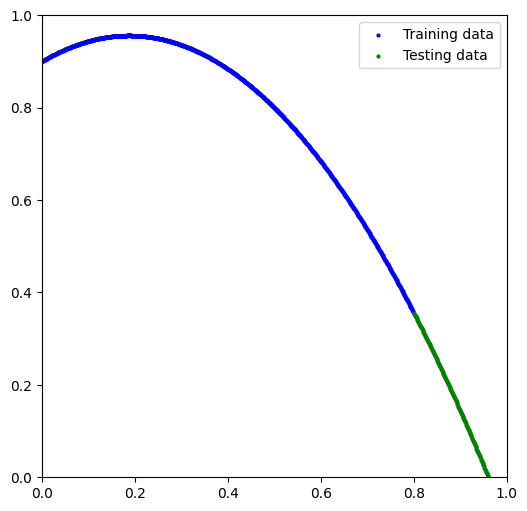

In [3]:
X = torch.arange(0, 1, 0.001).unsqueeze(dim=1)
y = -1.6 * X * X + 0.6 * X + 0.9
# y = 0.5 * X + 0.2

# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

helper.plot_predictions(X_train, y_train, X_test, y_test, None)

train_ds = TensorDataset(X_train, y_train)
print(f'TRAIN dataset size: {len(train_ds)}')

test_ds = TensorDataset(X_test, y_test)
print(f'TEST  dataset size: {len(test_ds)}')

In [49]:
torch.manual_seed(42)
class NonLinearModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)
    
model = NonLinearModel(1,10,1)
model

NonLinearModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

Epoch: 100 | MAE Train Loss: 0.001 | MAE Test Loss: 0.057 
Epoch: 200 | MAE Train Loss: 0.000 | MAE Test Loss: 0.028 
Epoch: 300 | MAE Train Loss: 0.000 | MAE Test Loss: 0.019 
Epoch: 400 | MAE Train Loss: 0.000 | MAE Test Loss: 0.015 
Epoch: 500 | MAE Train Loss: 0.000 | MAE Test Loss: 0.013 
Epoch: 600 | MAE Train Loss: 0.000 | MAE Test Loss: 0.012 
Epoch: 700 | MAE Train Loss: 0.000 | MAE Test Loss: 0.011 
Epoch: 800 | MAE Train Loss: 0.000 | MAE Test Loss: 0.010 
Epoch: 900 | MAE Train Loss: 0.000 | MAE Test Loss: 0.010 
Epoch: 1000 | MAE Train Loss: 0.000 | MAE Test Loss: 0.009 
Epoch: 1100 | MAE Train Loss: 0.000 | MAE Test Loss: 0.009 
Epoch: 1200 | MAE Train Loss: 0.000 | MAE Test Loss: 0.009 
Epoch: 1300 | MAE Train Loss: 0.000 | MAE Test Loss: 0.008 
Epoch: 1400 | MAE Train Loss: 0.000 | MAE Test Loss: 0.008 
Epoch: 1500 | MAE Train Loss: 0.000 | MAE Test Loss: 0.008 
Epoch: 1600 | MAE Train Loss: 0.000 | MAE Test Loss: 0.008 
Epoch: 1700 | MAE Train Loss: 0.000 | MAE Test Lo

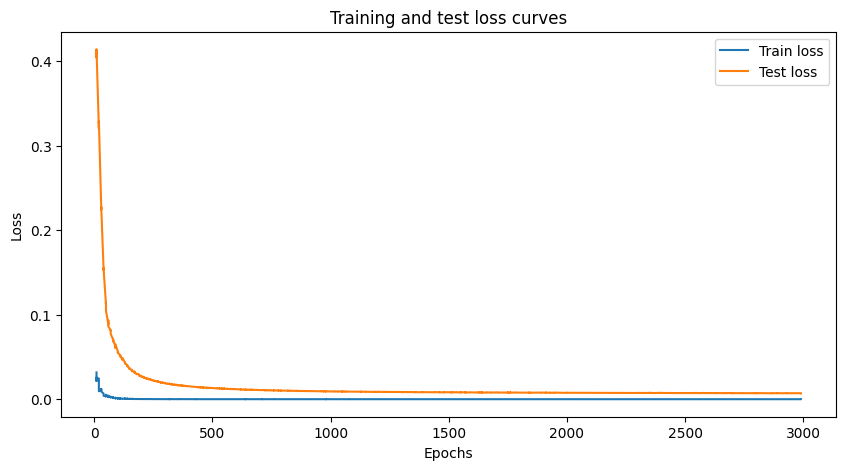

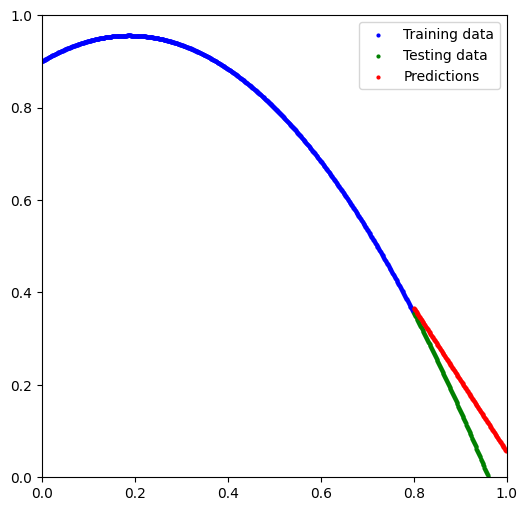

In [59]:
torch.manual_seed(42)
model_0 = NonLinearModel(1,10,1)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)

# loss_fn = nn.L1Loss() # MAE
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.05)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 3000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(1, epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        ### Training
        #
        # Forward pass
        outputs = model_0(inputs)
        loss = loss_fn(outputs, targets)
        #
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # gradient descent (update the parameters)

        ### Testing
        model_0.eval()
        with torch.inference_mode():
          test_pred = model_0(X_test) # forward pass
          test_loss = loss_fn(test_pred, y_test.type(torch.float))

          # Print out what's happening
          if epoch % 10 == 0:
                epoch_count.append(epoch)
                train_loss_values.append(loss.detach().numpy())
                test_loss_values.append(test_loss.detach().numpy())
                if i == 0 and epoch % 100 == 0:
                    print(f"Epoch: {epoch:2d} | MAE Train Loss: {loss:.3f} | MAE Test Loss: {test_loss:.3f} ")

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

with torch.inference_mode(): 
    y_preds = model_0(X_test)

helper.plot_predictions(X_train, y_train, X_test, y_test, y_preds)